### Part 1.2: Manually Solving Associative Recall with Attention

In [4]:
# DO NOT MODIFY
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import math
import numpy as np
import torch

from matplotlib.colors import Normalize
class LogLikeNorm(Normalize):
    """Log-like normalization scaling that includes 0."""
    def __init__(self, vmin=None, vmax=None, clip=False):
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # Handle normalization
        value = np.array(value, dtype=np.float64)
        norm_value = np.zeros_like(value)

        positive = value > 0
        norm_value[positive] = np.log10(value[positive] + 1)  # Log scaling for positive values
        norm_value[~positive] = 0  # Keep 0 as 0
        
        # Scale to [0, 1]
        norm_min = np.log10(self.vmin + 1) if self.vmin > 0 else 0
        norm_max = np.log10(self.vmax + 1) if self.vmax > 0 else 0
        return (norm_value - norm_min) / (norm_max - norm_min)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Generate a sample associative recall dataset

In [5]:
# DO NOT MODIFY
def generate_dataset(
    vocab_size: int = 50,
    num_examples: int = 1000,
    seed: int = 0,
) -> tuple[torch.Tensor, list[list[int]], list[list[int]]]:
    """
    Generate a dataset for the associative recall task.
    """
    # These are just seeding
    np.random.seed(seed)
    torch.manual_seed(seed)
    tokens = torch.arange(vocab_size)
    # Split tokens (numbers from 0 to vocab_size-1) into keys and values
    keys   = tokens[:vocab_size // 2]
    values = tokens[vocab_size // 2:]
    examples: list[torch.Tensor] = []
    repeated: list[list[int]] = []
    golds: list[list[int]] = []
    for _ in range(num_examples):
        shuffled_keys = keys[torch.randperm(len(keys))]
        shuffled_values = values[torch.randperm(len(values))]
        # Create a random mapping (bijection) from each key to a unique value
        kv_pairs = list(zip(shuffled_keys, shuffled_values))  
        # Choose several repeated (by 3 times) key-value pairs to use within as an example
        # An example will be a sequence of keys each followed by a corresponding value
        # We want the transformer to determine, from this sequence, which value
        # a given key maps to (i.e. next token prediction for after a key)
        example = kv_pairs[:2] * 3
        # Shuffle the order of these key value pairs
        example = [example[i] for i in torch.randperm(len(example))]
        # Construct list of positions of repeated keys in the example
        # (Note each index here is a pair!)
        repeat_pos: list[int] = []
        seen_keys: set[int] = set()
        for i, (k, _) in enumerate(example):
            if int(k) in seen_keys:
                repeat_pos.append(i * 2) # account for tupling of keys+values
            seen_keys.add(int(k))
        example_tensor = torch.tensor(example).flatten()
        examples.append(example_tensor)
        repeated.append(repeat_pos)
        golds.append([int(example_tensor[i+1]) for i in repeat_pos])
    return torch.stack(examples), repeated, golds

vocab_size=10
examples, repeated, golds = generate_dataset(vocab_size=vocab_size)
print("Example Input:", examples[0].tolist())
print("Indices of keys that are 'seen again' (repeated), to be scored:", repeated[0])
print("The keys that are repeated at those positions:", examples[0][repeated[0]].tolist())
print("Expected Associative Recall output for repeated keys (i.e. their values):", golds[0])

Example Input: [0, 9, 4, 8, 0, 9, 0, 9, 4, 8, 4, 8]
Indices of keys that are 'seen again' (repeated), to be scored: [4, 6, 8, 10]
The keys that are repeated at those positions: [0, 0, 4, 4]
Expected Associative Recall output for repeated keys (i.e. their values): [9, 9, 8, 8]


#### Understanding the Dataset

Example Input:&nbsp;&nbsp;&nbsp;&nbsp;[0, 9, 4, 8, 0, 9, 0, 9, 4, 8, 4, 8] \
Example Output:&nbsp;[0, 0, 0, 0, 9, 4, 9, 0, 8, 0, 8, 0] -- you can see this is the output in the very last line of the notebook! 

Each input is constructed by splitting our vocabulary (here the digits 0-9) into pairs of "keys" and "values". Each time a key appears in the sequence, it is always followed by its value; for example, the keys 0 and 4 in the example above are always followed by their values 9 and 8 respectively. We expect our model, once it has seen a key-value pair, to recognize that when it encounters the key again it will be followed by the same value.

Each item in the output is the 'next-token prediction' given the tokens seen so far in the input (i.e., we are doing causal language modeling):
- When we have the prefix '0', '0, 9', or '0, 9, 4', we don't know what the next token prediction should be, so we end up just seeing some random token '0' in the output (at the corresponding first three indices).
- When we have the prefix '0, 9, 4, 8, 0' we know that we've previously seen '9' follow a '0' so you can see that '9' appears in the 5th spot of the output vector as the next token prediction for prefix '0, 9, 4, 8, 0'.
- When we have the prefix '0, 9, 4, 8, 0, 9, 0, 9, 4', we have seen '8' follow '4' before. In the output vector, we see the '8'! Great!

So the intuition behind the prediction task we are aiming to solve here is to return the *token value* of the *token in the position directly after* this token, *where/if it appeared previously* in the sequence.

If you take a look at the data generation and scoring code we have provided (in `generate_dataset` and `score_solution`), we only calculate the accuracy of the model on positions that correspond to repeated keys (like the repeated 0 or repeated 4 we discussed in the bullets above). Only at these positions is there a deterministic "next-token" pattern - that the key's corresponding value should be the next token.

#### Embeddings
In this notebook, we will explore deriving from scratch the raw projection matrices using in attention ($W_Q$, $W_K$, and $W_V$) that will allow us to complete the above task. To do this, we will make use of two types of embeddings for each token in the input sequence: a *token embedding* (what token it is) and a *position embedding* (where in the sequence it shows up).


**Token Embeddings (One-Hot)**

In our code above, `vocab_size = 10` (our vocab is the digits 0-9). We embed each of these tokens as a [one-hot encoding](https://en.wikipedia.org/wiki/One-hot#Natural_language_processing).

Each row of the below plot displays the token embedding (a vector) of the corresponding token on the y-axis:


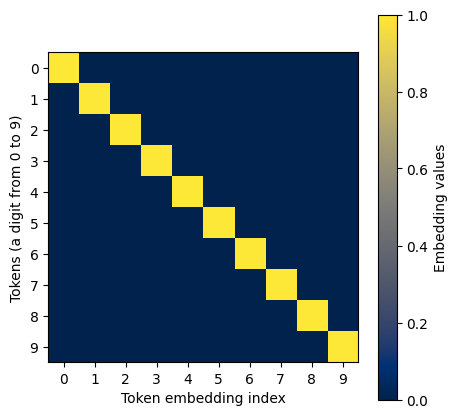

In [6]:
# DO NOT MODIFY
# Define the one-hot token embeddings
embeddings_init = torch.zeros(vocab_size, vocab_size)
for i in range(vocab_size):
    embeddings_init[i][i] = 1
    
print("Each row of the below plot displays the token embedding (a vector) of the corresponding token on the y-axis:")
plt.figure(figsize=(5, 5))
plt.imshow(embeddings_init.detach().numpy(), cmap='cividis')
plt.colorbar(label="Embedding values")
plt.xlabel("Token embedding index")
plt.ylabel("Tokens (a digit from 0 to 9)")
plt.xticks(range(vocab_size))
plt.yticks(range(vocab_size))
plt.show()

**Position Embedding**

For each position in the sequence, we also define a unique position embedding. All examples have a fixed length of 12, so we also use a one-hot encoding here.

All examples have a sequence length of 12
Each row of the below plot displays the positional embedding (a vector) of a position in the sequence:


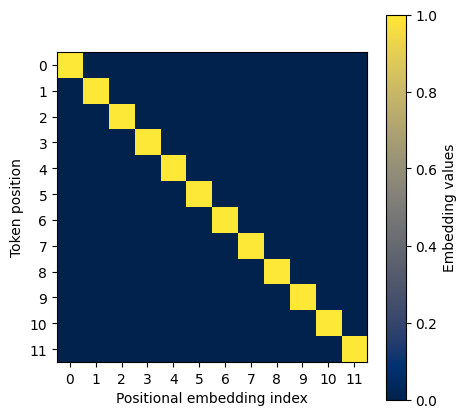

In [7]:
# DO NOT MODIFY
# Define the positional embeddings
batch_size, seq_len = examples.shape[0], examples.shape[1]
positional_encodings = torch.zeros((seq_len, seq_len))
for pos in range(seq_len):
    positional_encodings[pos][pos] = 1

print("All examples have a sequence length of", seq_len)
print("Each row of the below plot displays the positional embedding (a vector) of a position in the sequence:")
plt.figure(figsize=(5, 5))
plt.imshow(positional_encodings.detach().numpy(), cmap='cividis')
plt.colorbar(label="Embedding values")
plt.xlabel("Positional embedding index")
plt.ylabel("Token position")
plt.xticks(range(seq_len))
plt.yticks(range(seq_len))
plt.show()

From these, we now have two embeddings for each token in an example sequence - a token embedding encoding its meaning (which digit from 0 to 9 it is), and a positional embedding encoding its position within the sequence. We'll construct a *combined embedding* by concatenating these two embeddings for each token.

Be sure that you understand how this embedding is constructed, as this is crucial to how you'll determine the Q, K, and V projection weights later!

When debugging, you can change the value of `vis_idx` to the index of an example that you want to examine - this is used in this cell and later cells to determine what example to visualize intermediate calculations (e.g. $Q$, $K$, $V$, etc.) for. By default this is set to `0`, the first example.

Sequence length (vertical axis): 12
Embedding/model dimension (horizontal axis): 22
Visualizing the embeddings of [0, 9, 4, 8, 0, 9, 0, 9, 4, 8, 4, 8]:


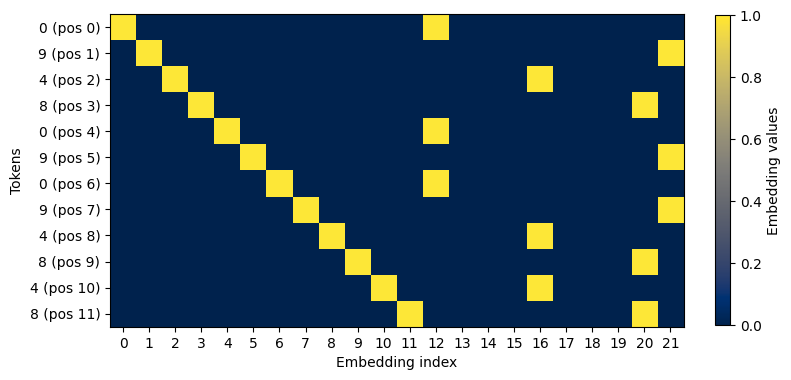

In [8]:
# DO NOT MODIFY
# Embed the input data
position_dim, embed_dim = positional_encodings.shape[1], embeddings_init.shape[1]
d_model = position_dim + embed_dim 
embs = torch.zeros((batch_size, seq_len, d_model))
for i in range(len(examples)):
    for j in range(seq_len):
        embs[i][j] = torch.concat((positional_encodings[j], embeddings_init[examples[i][j]]))

print(f"Sequence length (vertical axis): {seq_len}")
print(f"Embedding/model dimension (horizontal axis): {d_model}")

vis_idx = 0
vis_example = examples[vis_idx].tolist()
print(f"Visualizing the embeddings of {vis_example}:")

# Method used to visualize a batch of embeddings
def vis_embedding(example: list[int], emb: torch.Tensor, emb_name: str | None = None, log_scale: bool = False):
    plt.figure(figsize=(8, 5))
    plt.imshow(emb.detach().numpy(), cmap='cividis', norm=LogLikeNorm(0, 100) if log_scale else None)
    plt.colorbar(label="Embedding values", fraction=0.025)
    if emb_name is not None:
        plt.title(f"Embeddings for {emb_name}")
    plt.xlabel("Embedding index")
    plt.ylabel("Tokens")
    plt.xticks(range(d_model))
    plt.yticks(range(seq_len),  [f"{v} (pos {i})" for i, v in enumerate(example)])
    plt.show()

# Method used to visualize attention dot-product scores
def vis_attention_scores(example: list[int], attn_score: torch.Tensor, score_name: str | None = None):
    plt.figure(figsize=(5, 5))
    plt.imshow(attn_score.detach().numpy(), cmap='cividis')
    plt.colorbar(label="Dot product scores", fraction=0.045)
    if score_name is not None:
        plt.title(f"Attention dot-product scores for {score_name}")
    plt.xlabel("Queried-for tokens (in K)")
    plt.ylabel("Querying tokens (in Q)")
    plt.xticks(range(seq_len), [f"{v} (pos {i})" for i, v in enumerate(example)], rotation=45)
    plt.yticks(range(seq_len), [f"{v} (pos {i})" for i, v in enumerate(example)])
    plt.show()

vis_embedding(vis_example, embs[vis_idx])
# print(f'Shape of embeddings: {embs.shape} where {embs.shape[0]} is the batch size, {embs.shape[1]} is the sequence length, and {embs.shape[2]} is the embedding dimension')

Now you'll manually determine and set the input projection weights that are used to generate $Q$, $K$, and $V$ from the input $X$ to each attention layer of the transformer model. Recall that $Q$, $K$, and $V$ are created from linear transformations of $X$; we'll simplify this step to ignore any biases applied in this transformation, so we can represent it by matrix multiplication. In other words, $Q = XW_Q$, $K = XW_K$, $V = XW_V$ for some matrices $W_Q$, $W_K$, and $W_V$. 

In part 1.1, you should have hopefully determined that we need 2 attention layers to solve associative recall! Your job is to determine the weights of $W_Q$, $W_K$, and $W_V$ for each of these 2 attention layers to solve this task. As mentioned in the handout, we will use only one head of attention, and ignore the layer normalization and feed-forward network portions of the attention layer, for simplicity.

Some things to note when writing your implementation:
- The input $X$ to an attention layer is an $N \times D$ matrix, where $N$ is the sequence length and $D$ is the embedding dimension.
  - Here, $N$ is given by the variable `seq_len` and $D$ is given by `d_model`, where `d_model = seq_len + vocab_size`, as our embeddings were formed from the concatenation of token and positional embeddings.
  - Just like in the visualization above, we can think of $X$ as containing embeddings for each token on each row.
- $W_Q$, $W_K$, and $W_V$ are $D \times D$ matrices, such that $Q$, $K$, and $V$ are also $N \times D$ matrices. $Q$, $K$, and $V$ contain *transformed embeddings* for each token on each row (similar to $X$).
  - Every entry in a column of $Q$/$K$/$V$ is an entry in the transformed embeddings with the *same* index.
  - Each entry of $Q$/$K$/$V$ is given by the dot product of the corresponding row (i.e. embedding) of $X$ and the corresponding column of $W_Q$/$W_K$/$W_V$.
      - So, every entry in a column of $Q$/$K$/$V$ is calculated by a dot product of an embedding with the same corresponding column of $W_Q$/$W_K$/$W_V$. 
  - From these two points above, it's therefore helpful to think of **the columns of $W_Q$/$W_K$/$W_V$ as determining what should be selected out of each embedding in $X$** (by this dot product) **for the corresponding embedding index of each transformed embedding in $Q$/$K$/$V$**. We provide an example of this reasoning for $W_K$ for the first attention layer below.

**Your task is answer the questions regarding each layer and to fill in the 5 code blocks below**, manually setting the weights for $W_Q$, $W_K$, and $W_V$ for the two attention layers of the transformer. Each code block shouldn't require more than 1-2 lines of code.

#### Layer 1

Recall that we can intuitively think of the attention mechanism as a information retrieval mechanism from surrounding tokens. Each token retrieves information from all surrounding tokens that satisfy a certain characteristic. For each token, we determine a characteristic of other tokens we want to look for (a query, stored in $Q$). Then, for each token we also determine the degree to which it satisfies the searched-for characteristic (a key, stored in $K$). Lastly, for each token we determine the information about it we would want to retrieve (a value, stored in $V$) from each key.

Each row of $QK^T$ will correspond to a querying token (a token in $Q$) and each column will correspond to a searched-for token (a token in $K$). Each entry of $QK^T$ has a high value (score) if the characteristic that a querying token is looking for matches that of the searched-for token. Multiplying $QK^T$ (after some scaling) by $V$, we obtain, for each token in $Q$, a weighted sum of the information stored in $V$ across all tokens in $K$. In this weighted sum, the information from tokens in $V$ that match the desired characteristic is given greater weight (as determined by the scores in $QK^T$), while tokens that do not match as strongly contribute less.

For example, suppose that we wanted to have an attention layer that accounts for the meaning of adjectives that modify nouns in the input. $Q$ would contain, for each token $t$ at position $p_t$ that is a noun, an embedding representing "an adjective that modifies the token at position $p_t$" (this is the queried-for characteristic). $K$ would contain, for each token that is an adjective modifying the meaning of some other token $t^\prime$, an embedding representing "an adjective that modifies the token at position $p_{t^\prime}$". Lastly, $V$ would contain, for each token that is an adjective, an embedding representing the meaning of the adjective.

We'll use this idea for our two layers of attention. **The first layer will determine, for each token, what the token embedding of the previous token was.** We've given you what the keys should therefore be; your job is to also determine what the queries and values should therefore be. Your answer should be of the form "{this, the previous, the next} token's {token, position, combined} embedding".
 - each token's query will be **the previous token's position embedding**
 - each token's key will be **this token's position embedding**
 - each value will be **this token's token embedding**

In [10]:
# DO NOT MODIFY
# Initialize tensors for W_Q, W_K, W_V for first layer
print(f'init WQ, WK, WV with dim {d_model}x{d_model}')
WK1 = torch.zeros(d_model, d_model)
WQ1 = torch.zeros(d_model, d_model)
WV1 = torch.zeros(d_model, d_model)

init WQ, WK, WV with dim 22x22


**Define the weights of the projection matrix $W_K$ for the first attention layer!**

Using the hint above, each column of $W_K$ we can think of as weights determining what to select out of an input embedding for the corresponding index of the resulting embedding in $K$
- From above, we want to preserve only the position embedding from a combined embedding in the input
    - Note that the position embedding takes up the indices [0, `position_dim`) of the combined embedding
- Each column of $W_K$ in the range [0, `position_dim`) should therefore preserve only the entry at the same index from the input embedding
    - To do so, for each column index $i$ in the range [0, `position_dim`), only the entry in row $i$ is set to 1 (i.e. we only "snag" the entry at index $i$ from the input embedding; remember that we take the dot-product of an input embedding and this *column*, so each row in a column corresponds to an index in the input embedding)
- The remaining columns correspond to the token embeddings, which we want to zero out in $K$, and so remain all zeroes

Size of the Key Weights: torch.Size([22, 22])
Size of the Key Embeddings: torch.Size([1000, 12, 22])


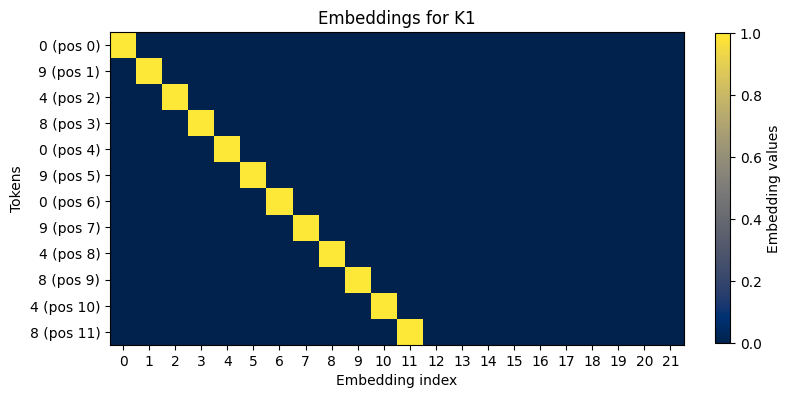

In [11]:
# DO NOT MODIFY
for col in range(position_dim):
    WK1[col, col] = 1

print(f'Size of the Key Weights: {WK1.shape}')

K1 = embs @ WK1
print(f'Size of the Key Embeddings: {K1.shape}')
vis_embedding(vis_example, K1[vis_idx], "K1")

**Define the weights of the projection matrix $W_Q$ for the first attention layer!**

Hint: For *all* projection matrices, their weights should select out certain parts of the input embeddings; in other words, your weight matrices should consist of only 0s and 1s.

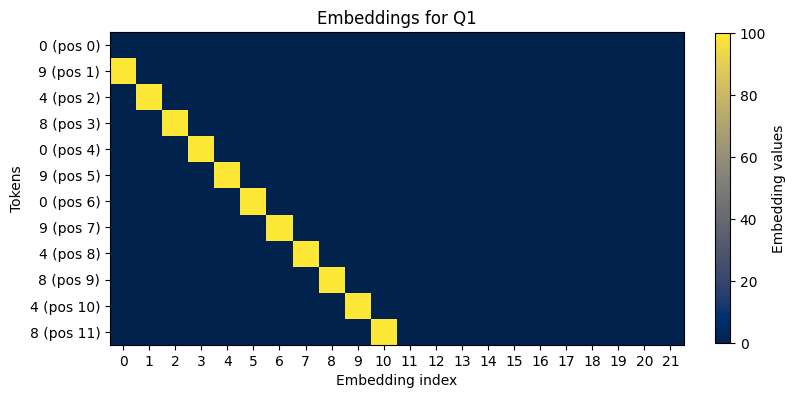

In [12]:
# TODO: determine the weights of `WQ1`!
for i in range(1, position_dim):
    WQ1[i, i-1] = 1

Q1 = embs @ WQ1 * 100 # keep the scores we want high after softmax -- softmax makes the distribution spikey
vis_embedding(vis_example, Q1[vis_idx], "Q1")

**Define the weights of the projection matrix $W_V$ for the first attention layer!**

From above, we want each token's embedding in the output $O$ of this layer to be the previous token's token embedding. We'll need to rearrange these token embeddings, however, to be at the *beginning* of each embedding in $O$, rather than at the end. Our attention layer employs residual connections, so the input to the attention layer is added to its output. The next layer will want to use this token *and* the previous token's token embedding, the latter of which is stored at the end of the input embedding. By positioning these two pieces of information in separate parts of the embedding, adding them will preserve both; you can see this in the expected output on the last line of this notebook.

*Be sure to account for this in how you set the weights of $W_V$!*

(Note that the input embeddings will also contain their position embeddings at the beginning. We therefore scale $W_V$ and therefore the layer's output by a large factor, such that when it is added to the input embeddings, the output embeddings dominate the position embeddings located at the same embedding indices.)

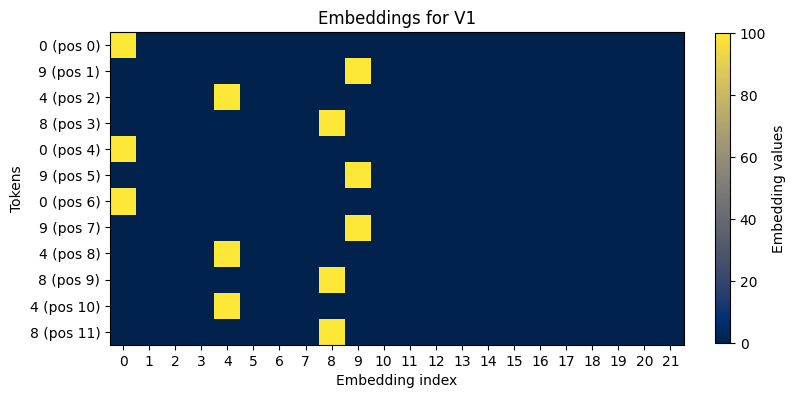

In [13]:
# TODO: determine the weights of `WV1`!
for i in range(vocab_size):
    WV1[i + position_dim, i] = 1

V1 = embs @ WV1 * 100 # weight the layer's output more compared to the original input to the attention layer that it's added to
vis_embedding(vis_example, V1[vis_idx], "V1")

In [14]:
print(examples[vis_idx])
# Print the shapes of Q, K, and V
print(f"Shape of Q1: {Q1.shape}")
print(f"Shape of K1: {K1.shape}")
print(f"Shape of V1: {V1.shape}")

tensor([0, 9, 4, 8, 0, 9, 0, 9, 4, 8, 4, 8])
Shape of Q1: torch.Size([1000, 12, 22])
Shape of K1: torch.Size([1000, 12, 22])
Shape of V1: torch.Size([1000, 12, 22])


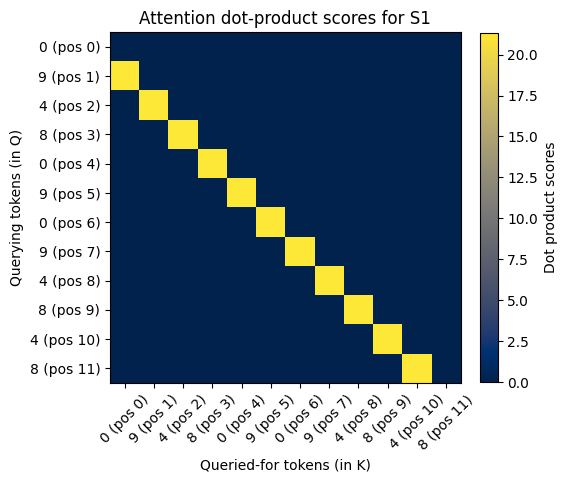

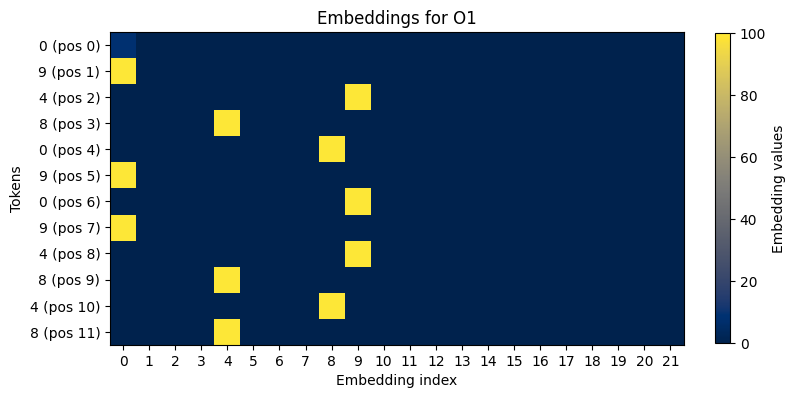

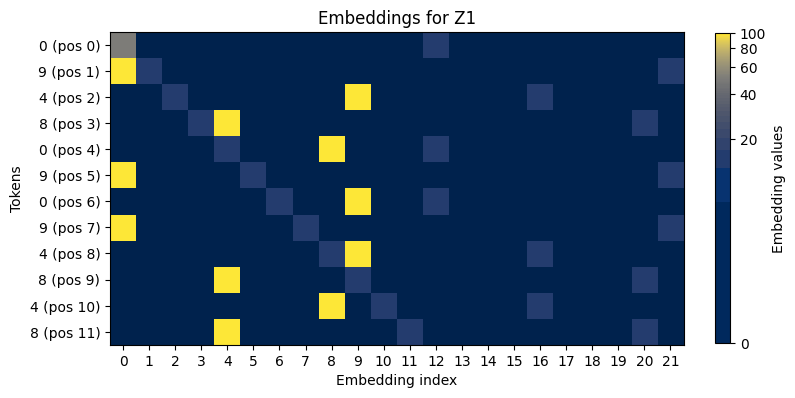

In [15]:
# DO NOT MODIFY
# Perform attention
S1 = Q1 @ K1.transpose(1, 2) / math.sqrt(d_model)
O1 = torch.tril(torch.softmax(S1, dim=-1)) @ V1
Z1 = O1 + embs

vis_attention_scores(vis_example, S1[vis_idx], "S1")
vis_embedding(vis_example, O1[vis_idx], "O1")
vis_embedding(vis_example, Z1[vis_idx], "Z1", log_scale=True)

Where are we now?
- `Z1` will contain the token embeddings of each previous token at the start of each embedding (from `O1`)
- `Z1` will contain the original token embeddings at the end of each embedding (from `embs`)

#### Layer 2: 

The goal of this layer is to determine, for each token, the token embeddings of tokens that immediately succeed it when it appears in the input sequence. Your job is to determine what the queries, keys, and values should therefore be. Your answer should be of the form "{this, the previous, the next} token's {token, position, combined} embedding". (Consider what information you have actually available in `Z1`!)
 - each token's query will be **the next token's position embedding**
 - each token's key will be **this token's position embedding**
 - each value will be **this token's token embedding**

In [16]:
# DO NOT MODIFY
# Initialize tensors for W_Q, W_K, W_V for second layer
WK2 = torch.zeros(d_model, d_model)
WQ2 = torch.zeros(d_model, d_model)
WV2 = torch.zeros(d_model, d_model)

# Print shapes
print(f'init WQ, WK, WV with dim {d_model}x{d_model}')

init WQ, WK, WV with dim 22x22


**Define the weights of the projection matrix $W_K$ for the second attention layer!**

Note where embeddings are stored in the input embeddings from `Z1`; you'll want the embeddings in $K$ to be at the same indices as the embeddings in $Q$ (such that they match when performing $QK^T$)!

W_K2 has 22 rows and 22 columns


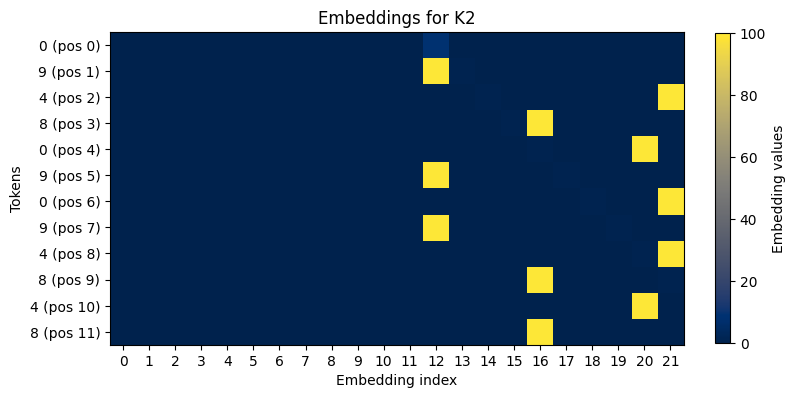

In [17]:
# TODO: determine the weights of `WK2`!
for i in range(position_dim, d_model):
    WK2[i - position_dim, i] = 1 

print(f'W_K2 has {WK2.shape[0]} rows and {WK2.shape[1]} columns')

K2 = Z1 @ WK2
vis_embedding(vis_example, K2[vis_idx], "K2")

**Define the weights of the projection matrix $W_Q$ for the second attention layer!**

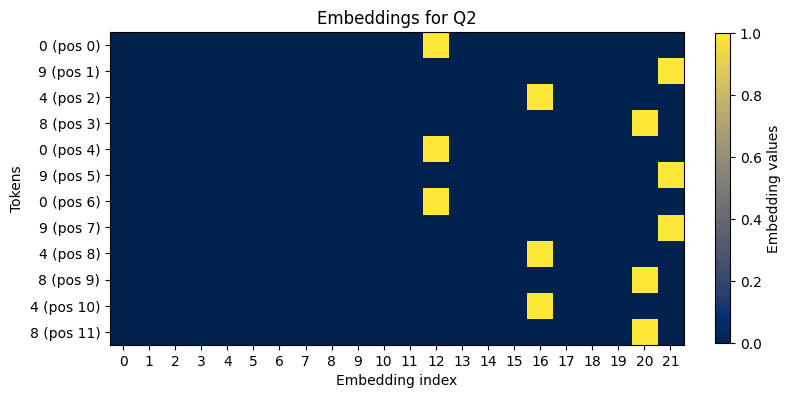

In [18]:
# TODO: determine the weights of `WQ2`!
for i in range(position_dim, d_model):
    WQ2[i, i] = 1


Q2 = Z1 @ WQ2
vis_embedding(vis_example, Q2[vis_idx], "Q2")

**Define the weights of the projection matrix $W_V$ for the second attention layer!**

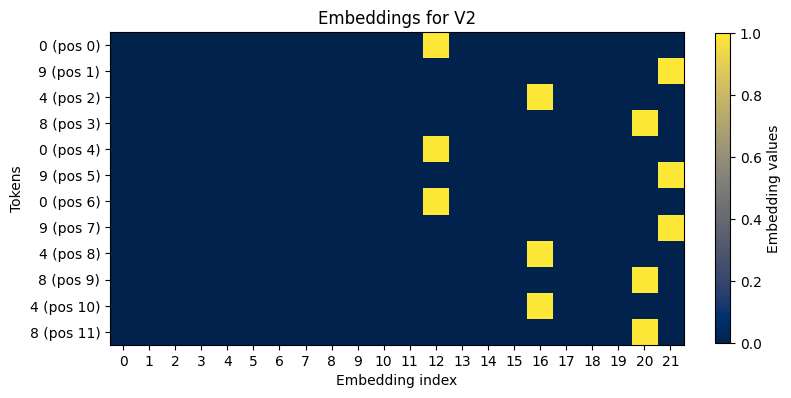

In [19]:
# TODO: determine the weights of `WV2`!
for i in range(vocab_size):
    # map token i to position d_model - vocab_size + i
    WV2[position_dim + i, position_dim + i] = 1


V2 = Z1 @ WV2
vis_embedding(vis_example, V2[vis_idx], "V2")

With your defined weights for $W_K$, $W_Q$, and $W_V$, the layer's output should contain, for each token, the embedding of any token(s) in the input sequence that immediately succeeded it when it appeared. As we apply causal masking, this output is limited to any token(s) that immediately succeeded it when it appeared *priorly* in the input sequence.

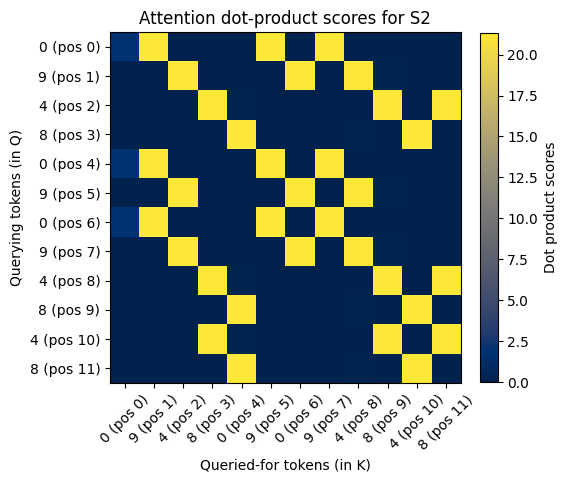

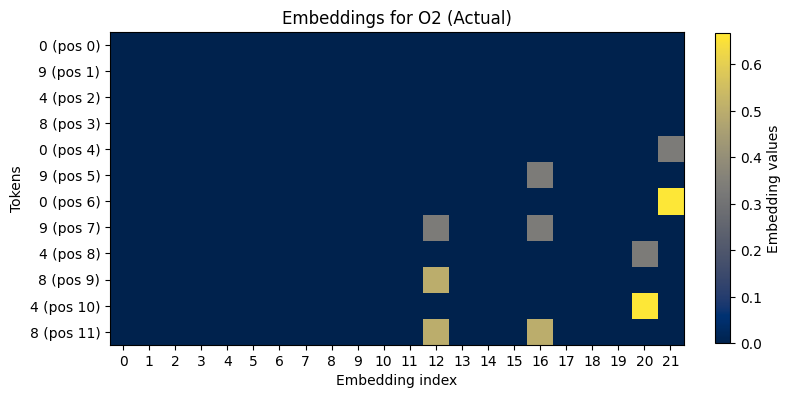

In [20]:
# DO NOT MODIFY
# Perform attention
S2 = Q2 @ K2.transpose(1, 2) / math.sqrt(d_model)
O2 = torch.tril(torch.softmax(S2, dim=-1)) @ V2

vis_attention_scores(vis_example, S2[vis_idx], "S2")
vis_embedding(vis_example, O2[vis_idx], "O2 (Actual)")

Below, we are going to apply a "language modeling head" to our 2nd attention layer's output to get the transformer's next token predictions for the sequence.

We will do this by taking the argmax of the output `O2` -- in other words, the embedding indices in `O2` that have the highest value for each embedding. For the model you trained using `lm.py` in part 1.1 of this assignment, there was a softmax operation applied after all the attention layers, and we outputted the token with the highest softmax score; using argmax is the same idea.

In [21]:
# DO NOT MODIFY
Z2 = torch.argmax(O2, dim=-1)

print(Z2[vis_idx].tolist())

[12, 12, 12, 12, 21, 16, 21, 12, 20, 12, 20, 12]


Finally, remember that when we constructed our embeddings for the sequence, we had position embeddings concatenated with token embeddings. With our one-hot encoding of embeddings, each token 0-9 was represented having its corresponding index in its token embedding be the highest value. These indices, due to this concatenation, were shifted by the length of the position embeddings, so let's subtract off by `position_dim` to give us the token embedding indices with the highest value, i.e. our token predictions.

In [22]:
# DO NOT MODIFY
predictions = torch.maximum(Z2 - position_dim, torch.zeros(Z2.shape, dtype=torch.int))

print(predictions[vis_idx].tolist())

[0, 0, 0, 0, 9, 4, 9, 0, 8, 0, 8, 0]


### Score the Results

You should see perfect accuracy printed.

In [23]:
def score_solution(
    repeated: list[list[int]], 
    predictions: torch.Tensor,
    golds: list[list[int]],
) -> list[int]:
    """
    Score a solution to the associative recall task.
    golds is [batch_size x num_golds]
    predictions is [batch_size x seq_len]
    """
    correct = 0
    total = 0
    incorrect_examples: list[int] = []
    for idx, (gold, repeat_positions, preds) in enumerate(zip(golds, repeated, predictions)):
        assert len(repeat_positions) == len(gold), print(f"{idx}: {len(repeat_positions)} != {len(gold)} -- repeat: {repeat_positions}, gold: {gold}")
        num_correct = len([True for j, i in enumerate(repeat_positions) if gold[j] == preds[i]])
        correct += num_correct
        total += len(gold)
        if num_correct != len(gold):
            incorrect_examples.append(idx)
    print(f"Accuracy: {correct / total * 100:.2f}%, sample size of {total} from {len(examples)} examples")
    return incorrect_examples

incorrect_indices = score_solution(repeated, predictions, golds)
print(f"Examples with the following indices were not correctly predicted: {incorrect_indices[:10]}")

Accuracy: 100.00%, sample size of 4000 from 1000 examples
Examples with the following indices were not correctly predicted: []


### Expected Outputs

Run the cell below to see the expected outputs of layer 1 and layer 2 for `vis_idx = 0`

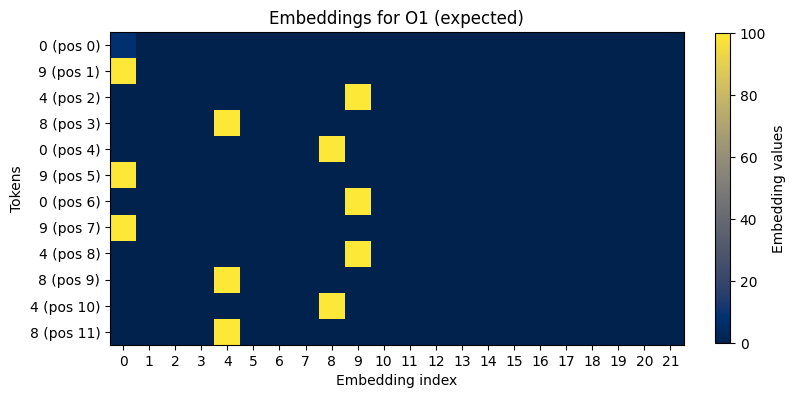

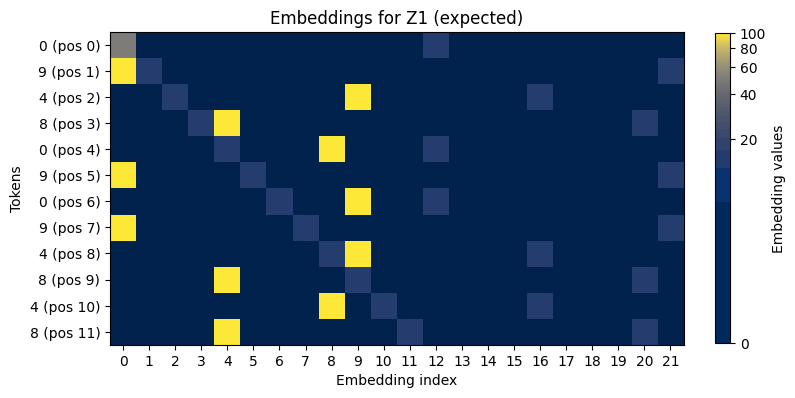

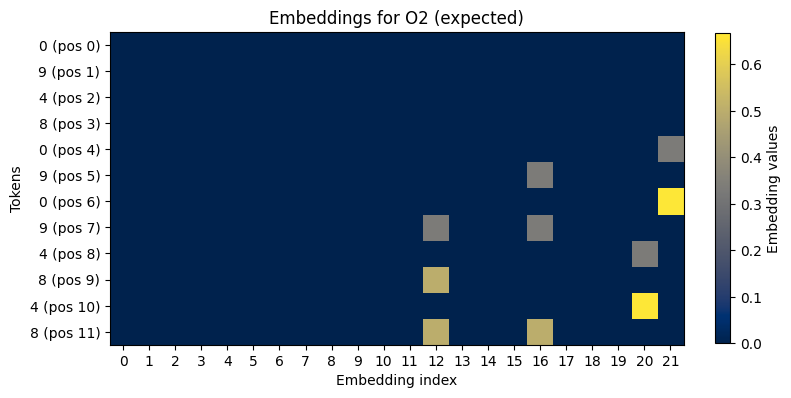

Expected predictions: [0, 0, 0, 0, 9, 4, 9, 0, 8, 0, 8, 0]


In [24]:
expected = torch.load("data/expected.pt", weights_only=True)
vis_embedding(vis_example, expected[0], "O1 (expected)")
vis_embedding(vis_example, expected[1], "Z1 (expected)", log_scale=True)
vis_embedding(vis_example, expected[2], "O2 (expected)")

expected_predictions = torch.maximum(torch.argmax(expected[2], dim=-1) - position_dim, torch.zeros(expected[2].shape[:-1], dtype=torch.int)).tolist()
print(f"Expected predictions: {expected_predictions}")